In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn as sk

In [2]:
X_train = np.load("./aug_images_train.npy")
y_train = np.load("./aug_label_train.npy")

In [3]:
Y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [4]:
X.shape

(1344, 128, 128, 3)

In [3]:
X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.float32)

In [6]:
print (Y)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]


In [3]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)

In [8]:
Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [9]:
Y.shape

(1344, 2)

In [10]:
tf.__version__

'2.7.0'

In [4]:
from sklearn.model_selection import train_test_split
X_test, y_test = np.load("./images_test_3d.npy"), np.load("./labels_test.npy")
y_test = to_categorical(y_test)

In [28]:
y_train.shape 

(2144, 2)

In [29]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [7]:
# X_val_train , X_val_test , y_val_train , y_val_test = train_test_split(X_test, y_test , test_size=0.5 , random_state=4)

In [5]:

from loader import load_train_data

def preprocess(x, y):
    xp = keras.applications.resnet.preprocess_input(x)
    yp = keras.utils.to_categorical(y, 2)

    return xp, yp

# Input Images => 200x RGB 256x256
# Ouput => True/False
X, Y = preprocess(X_train,y_train) 

input_tensor = keras.Input(shape=X.shape[1:])
densenet = keras.applications.DenseNet121(include_top=False, weights="imagenet", input_tensor=input_tensor)

# # # Freeze all blocks except last
print(len(densenet.layers))
for l in list(densenet.layers)[:143]:
    l.trainable = False

model = keras.models.Sequential()
model.add(keras.layers.Lambda(lambda im: tf.image.resize(im, (128, 128))))
model.add(densenet)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(lr=0.001),
                metrics=['accuracy'])

model.build(input_shape=(None ,128,128,3))
print(model.summary())

427


/home/computer/anaconda3/envs/mcgan/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKerasTF
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.0002, mode='auto')
# checkpoint = ModelCheckpoint("dense_net1.h5", monitor='val_accuracy',
#                              save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), reduce_lr]

In [7]:
y_train.shape

(1072, 2)

In [18]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

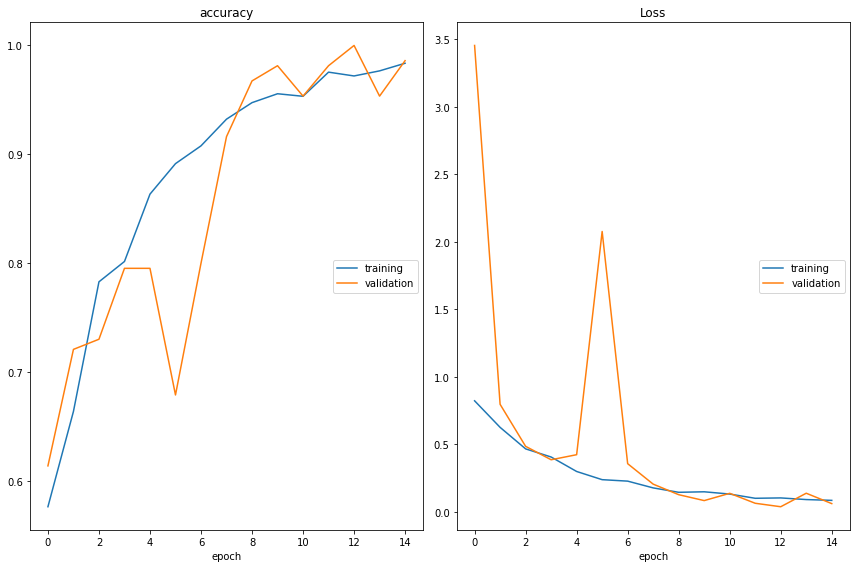

accuracy
	training         	 (min:    0.576, max:    0.984, cur:    0.984)
	validation       	 (min:    0.614, max:    1.000, cur:    0.986)
Loss
	training         	 (min:    0.086, max:    0.823, cur:    0.086)
	validation       	 (min:    0.039, max:    3.454, cur:    0.062)
27/27 [==============================] - 3s 129ms/step - loss: 0.0860 - accuracy: 0.9837 - val_loss: 0.0620 - val_accuracy: 0.9860 - lr: 2.0000e-04
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autogr

In [8]:
history = model.fit(X_train,y_train,batch_size = 32,
                              epochs=15, 
                              shuffle=True, 
                              verbose=True,
                              validation_split=0.2,
                              callbacks=callbacks,
                              )
model.save("saved/densenet")

In [9]:
model_test = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
model_test[1]

array([0.02568019, 0.9743198 ], dtype=float32)

In [11]:
new_model_test = []
for i in model_test :
    if i[0] > i[1] :
        new_model_test.append(0)
    else :
        new_model_test.append(1)

In [23]:
new_model_test

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [24]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.

In [25]:
y_test[0]

array([1., 0.], dtype=float32)

In [12]:
new_y_test = []
for i in y_test : 
    print(i)
    
    if int(i[0]) == 1 :
        new_y_test.append(0)
    else : 
        new_y_test.append(1)

[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[1. 0.]


In [27]:
new_y_test

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [13]:
import matplotlib.pyplot as plt

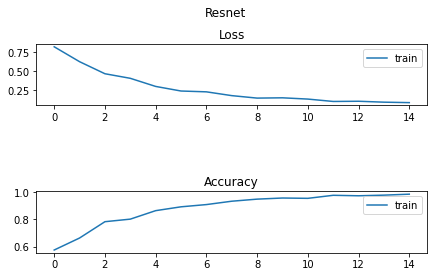

In [14]:
fig = plt.figure(figsize=(7, 4))
fig.suptitle("Resnet")
fig.subplots_adjust(top=0.85)
plt.title("Resnet")

plt.subplot(311)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
# py.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(313)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
# py.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
 

In [15]:
import itertools

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.get_cmap("Blues")):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
val = sk.metrics.precision_recall_fscore_support(new_y_test , new_model_test,average=None )
print("Precision for resnet : ", round(val[0][1] *100) , "% and average is : ",round(val[0][0]*100),"% ")
print("Recall for resnet : ", round(val[1][1]*100) , "% and average is : ",round(val[1][0]*100),"% ")
print("f1score for resnet : ", round(val[2][1]*100) , "% and average is : ",round(val[2][0]*100),"% ")

Precision for resnet :  100 % and average is :  100 % 
Recall for resnet :  100 % and average is :  100 % 
f1score for resnet :  100 % and average is :  100 % 


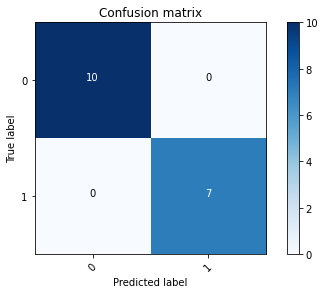

In [18]:
conf = sk.metrics.confusion_matrix(new_y_test , new_model_test)
plot_confusion_matrix(conf,classes=[0 , 1])

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [20]:
prec = accuracy_score(new_y_test , new_model_test)
round(prec*100)

100